In [ ]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

In [ ]:
# calibrating camera.
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
# chessboard size is 9 x 6.
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] 
imgpoints = [] 

# Read chessboard image files.
# these are used to calibrate the camera.
images = glob.glob('camera_cal/calibration*.jpg')

In [3]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cornered_found_file = 'output_images/calibration_camera_images/calibration_with_corners_' + str(idx) + '.jpg'
        cv2.imshow('img', img)
        cv2.imwrite(cornered_found_file, img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

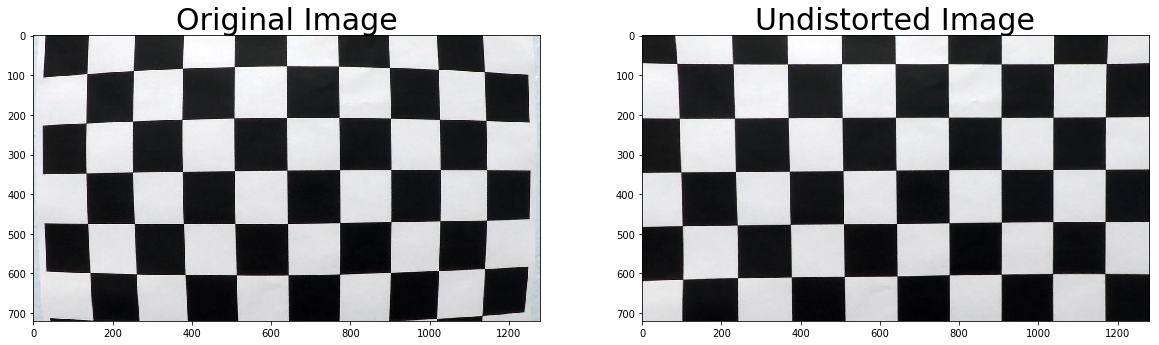

In [4]:
import pickle
%matplotlib inline

# Test undistortion on an image using one of the images, calibration1.jpg
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# save undistorted image.
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration_camera_images/calibration1_undistorted.jpg',dst)

# Save the camera calibration result for later use
# we need to save mtx and dist
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "calibrated/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

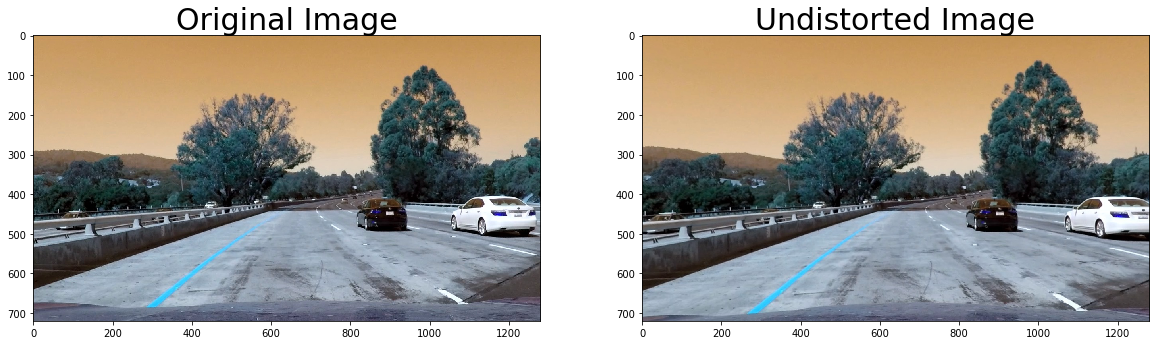

In [35]:
# Pick one file for a quick test. 
# just want to test one image.
# dst is undistorted image.
img = cv2.imread('test_images/test1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration_camera_images/test1_undistorted.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [36]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # convert it to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else: # orient is 'y'
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def color_thresh(img, sthresh=(0, 255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
       
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    #plt.imshow(sbinary)
    return sbinary

def gray_thresh(img, gthresh=(0, 255)):
    img = np.copy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
       
    binary = np.zeros_like(gray)
    binary[(gray > gthresh[0]) & (gray <= gthresh[1])] = 1
    return binary
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    sobel_abs = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    sxbinary = np.zeros_like(grad_dir)
    sxbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    #plt.imshow(sxbinary)
    return sxbinary

def color_transform(dst):
    combinedImage = np.zeros_like(dst[:,:,0])
    gradx = abs_sobel_thresh(dst, orient='x', thresh=(12, 255))
    grady = abs_sobel_thresh(dst, orient='y', thresh=(80, 255))

    colorbinary = color_thresh(dst, sthresh=(80, 255)) 
    #graybinary = gray_thresh(dst, gthresh=(180, 255))
    # tried mag_binary but it seemed to make the lines thinner.
    #mag_binary = mag_thresh(dst, mag_thresh=(150, 255))  
    # dir_binary also seems to hinder the line detection, too.
    #dir_binary = dir_threshold(dst, thresh=(0.3, 1.5))
    #combinedImage[((gradx == 1) & (grady == 1)) | (colorbinary == 1)] = 255
    #tried gradx but it doesn't seem to be necessary.  remove gradx.
    combinedImage[((gradx == 1) & (grady == 1)) | (colorbinary == 1)] = 255
    plt.imshow(combinedImage, cmap='gray')
    binary_image_file = 'output_images/binary_images/binary_image_' + str(idx) + '.jpg'
    cv2.imwrite(binary_image_file, combinedImage)
    return combinedImage


In [37]:
# prespective transformation
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    #x_perc_top = 0.48
    x_perc_top = 0.45
    x_perc_bot = 0.20
    #y_perc_top = 0.63
    y_perc_top = 0.63
    y_perc_bot = 0.98
    x_offset = 0.09*img_size[0]  # added x_offset since the camera is not center.
    src = np.float32(
    [[img_size[0]*x_perc_top, img_size[1]*y_perc_top],
    [img_size[0]*x_perc_bot, img_size[1]*y_perc_bot],
    [img_size[0]*(1-x_perc_bot), img_size[1]*y_perc_bot],
    [img_size[0]*(1-x_perc_top), img_size[1]*y_perc_top]]
    )
    #[img_size[0]*(1-x_perc_bot)+x_offset, img_size[1]*y_perc_bot],
    #[img_size[0]*(1-x_perc_top)+x_offset, img_size[1]*y_perc_top]]
    #)
    
    #offset_x = 0.20*img_size[0]  # 0.2 seems to be a good value after playing around.
    offset_x = 0.2*img_size[0]
    destination = np.float32(
    [[offset_x, 0],
    [offset_x, img_size[1]],
    [img_size[0]-offset_x, img_size[1]],
    [img_size[0]-offset_x, 0]]
    )

    M = cv2.getPerspectiveTransform(src, destination) 
    Minv = cv2.getPerspectiveTransform(destination, src)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, Minv

def warped_image(combinedImage):
    warped, Minv = warp(combinedImage)
    plt.imshow(warped)
    warped_image_file = 'output_images/warped_images/warped_image_' + str(idx) + '.jpg'
    cv2.imwrite(warped_image_file, warped)
    return warped, Minv


In [38]:
def sliding_window(warped, Minv):
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    #plt.plot(histogram)
    out_img = np.dstack((warped, warped, warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # choose number of sliding windows.
    nwindows = 18
    window_height = np.int(warped.shape[0]/nwindows)  # this should be 720/nwindows

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base 
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    #margin = 80
    margin = 30
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #Step through the windows one by one
    for window in range(nwindows):  # window 0 to 8
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height #first value 640
        win_y_high = warped.shape[0] - window*window_height # first value 720
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        #plt.imshow(out_img)
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # visualization
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    with_windows_image_file = 'output_images/images_with_sliding_windows/windows_image_' + str(idx) + '.jpg'
    cv2.imwrite(with_windows_image_file, out_img)


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    middle_line = np.hstack((left_line_window2, right_line_window1))

    #
    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    cv2.fillPoly(road, np.int_([left_line_pts]), color=[255,0,0])
    cv2.fillPoly(road, np.int_([right_line_pts]), color=[0,0,255])
    cv2.fillPoly(road, np.int_([middle_line]), color=[0,255,0])
    cv2.fillPoly(road_bkg, np.int_([left_line_pts]), color=[255,255,255])
    cv2.fillPoly(road_bkg, np.int_([right_line_pts]), color=[255,255,255])

    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    road_warped = cv2.warpPerspective(road,Minv,img_size, flags=cv2.INTER_LINEAR)
    road_bkg_warped = cv2.warpPerspective(road_bkg,Minv,img_size, flags=cv2.INTER_LINEAR)
    bkg = cv2.addWeighted(img, 1.0, road_bkg_warped, -1.0, 0.0)
    results = cv2.addWeighted(bkg, 1.0, road_warped, 1.0, 0.0)
    plt.imshow(results)
    plt.show()
    line_image_file = 'output_images/line_images/road_image_' + str(idx) + '.jpg'
    cv2.imwrite(line_image_file, results)

    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 10/720 # meters per pixel in y dimension
    xm_per_pix = 4/384 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(np.array(lefty,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(righty,np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix, 2)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')

    cv2.putText(results, "Radius of Curvature: LEFT = " + str(round(left_curverad, 3)) + " m ", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
    cv2.putText(results, "Radius of Curvature: RIGHT = " + str(round(right_curverad, 3)) + " m ", (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

    camera_center_at_bottom = (left_fitx[-1]+right_fitx[-1])/2
    center = warped.shape[1]/2
    center_diff = (camera_center_at_bottom - center)*xm_per_pix
    location = 'left'
    if center_diff < 0:
        location = 'right'
    cv2.putText(results, "Position: " + str(round(center_diff, 3)) + " m " + location + "", (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)

    plt.imshow(results)
    plt.show()
    results_with_info = 'output_images/results_with_curv_info/info_image_' + str(idx) + '.jpg'
    cv2.imwrite(results_with_info, results)

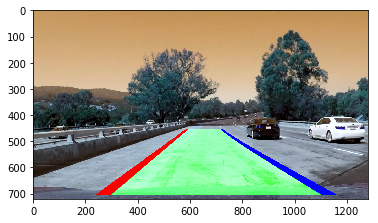

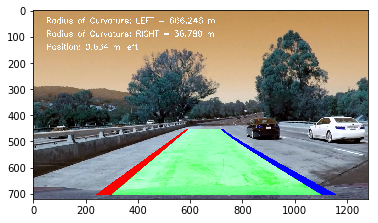

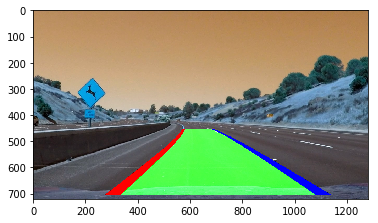

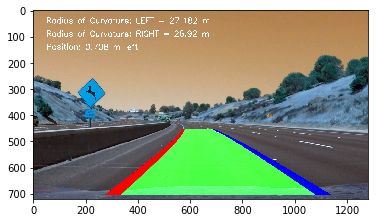

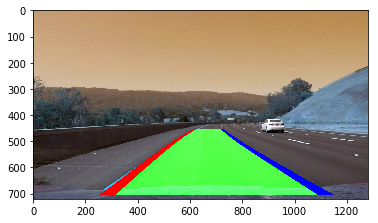

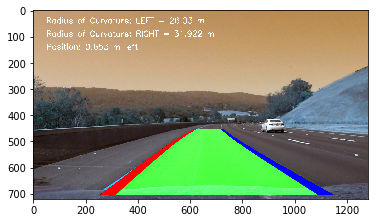

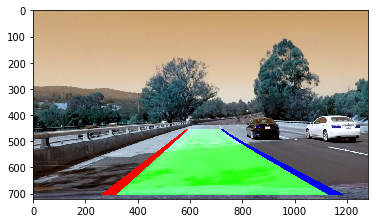

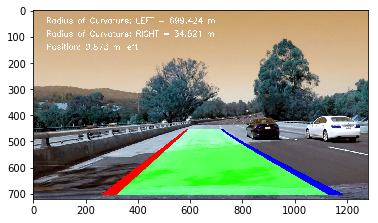

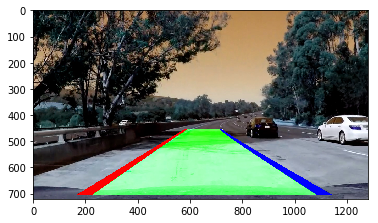

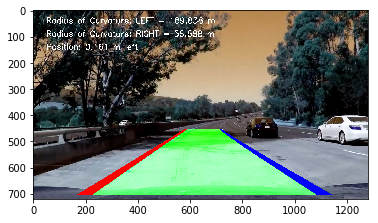

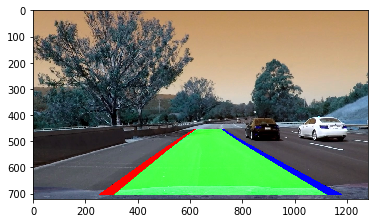

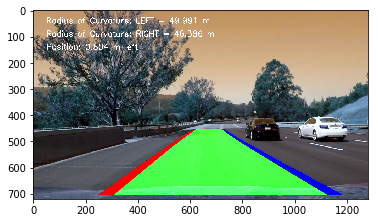

In [39]:
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_file = 'output_images/undistorted_test_images/test_undistorted_' + str(idx) + '.jpg'
    cv2.imwrite(undistorted_file, dst)
    
    combinedImage = color_transform(dst)
    warped, Minv = warped_image(combinedImage)
    sliding_window(warped, Minv)  